<ipython-input-2-09b2585cad7d>:24: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (1, 60, 1)                24        
                                                                 
 gru_2 (GRU)                 (1, 60, 1)                12        
                                                                 
 gru_3 (GRU)                 (1, 60, 1)                12        
                                                                 
 dense_2 (Dense)             (1, 60, 10)               20        
                                                                 
 dense_3 (Dense)             (1, 60, 1)                11        
                                                                 
Total params: 79
Trainable params: 55
Non-trainable params: 24
_________________________________________________________________
None
Epoch: 0
114/114 [==============================] - 

<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 20ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 21ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 21ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 20ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 21ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 25ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 20ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 21ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 21ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 20ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 19ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 21ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 20ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 21ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 20ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 23ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 24ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 22ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 20ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 21ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 22ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 24ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 20ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 30ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)


1/1 [==============================] - 0s 26ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)


1/1 [==============================] - 0s 33ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)


1/1 [==============================] - 0s 28ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)


1/1 [==============================] - 0s 29ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)


1/1 [==============================] - 0s 30ms/step
Forecasting Testing Data


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)


1/1 [==============================] - 0s 39ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)


1/1 [==============================] - 0s 19ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 22ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 21ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 21ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 22ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 24ms/step


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-inpu

1/1 [==============================] - 0s 22ms/step
Training time :  29.65814781188965
Testing time :  1.8357210159301758
Train RMSE: 10.626
Train RMSPE: 5.536
Train MAE: 10.62288
Train MAPE: 5.15951
r2 score for training model is 0.9854993287041185
raw_values =  (144, 1) 29
Test RMSE: 10.538
Test RMSPE: 2.483
Test MAE: 10.53636
Test MAPE: 2.45069
r2 score for testing model is 0.9820483810463269


<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)
<ipython-input-2-09b2585cad7d>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(new_row)


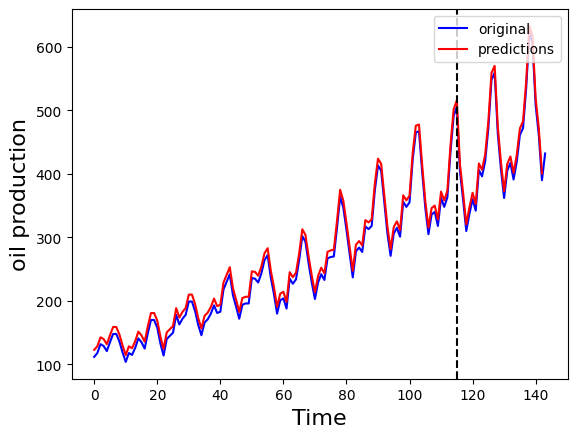

In [2]:
import numpy as np
import tensorflow.compat.v1 as tf
import random as rn
import numpy as np
import pandas as pd
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(1)
rn.seed(1)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K
tf.set_random_seed(1)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
tf.keras.backend.set_session(sess)

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import QuantileTransformer
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization
from keras.layers import LSTM,GRU
from keras.constraints import max_norm
from math import sqrt
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
from numpy import concatenate
from sklearn.metrics import r2_score
import time
def parser(x):
  return datetime.strptime(x, '%Y%m')

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
  # fit scaler
  scaler = QuantileTransformer(n_quantiles=15, random_state=0,output_distribution='normal') #
  scaler = scaler.fit(train)
  
  # transform train
  train = train.reshape(train.shape[0], train.shape[1])
  train_scaled = scaler.fit_transform(train)
  # transform test
  test = test.reshape(test.shape[0], test.shape[1])
  test_scaled = scaler.fit_transform(test)
  return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
  new_row = [x for x in X] + [value]
  array = np.array(new_row)
  array = array.reshape(1, len(array))
  inverted = scaler.inverse_transform(array)
  return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
  X, y = train[:, 0:-1], train[:, -1]
  X = X.reshape(X.shape[0], X.shape[1],1 )
  model1 = Sequential()
  model1.add(LSTM(neurons[0], batch_input_shape=(batch_size, X.shape[1], X.shape[2]) , stateful=True,return_sequences = True))
  model1.add(LSTM(neurons[1], batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True,return_sequences = True))

  # Freeze the base model
  model1.trainable = False
  model = Sequential()
  model.add(model1)

  model.add(GRU(neurons[0], batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True,return_sequences=True))
  model.add(GRU(neurons[1], batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True,return_sequences=True))

  model.add(Dense(10, activation='elu'))
  model.add(Dense(1))
       
  model.compile(loss='mean_squared_error', optimizer='adam')

  print(model.summary())
 
  for i in range(nb_epoch):
    print('Epoch:',i)
    model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()
  return model
  

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
  X = X.reshape(1, len(X), 1)
  yhat = model.predict(X, batch_size=batch_size)
  return yhat[0,0]

# Update LSTM model
def update_model(model, train, batch_size, updates):
  X, y = train[:, 0:-1], train[:, -1]
  X = X.reshape(X.shape[0], X.shape[1],1 )
  for i in range(updates):
    model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataset = np.insert(dataset,[0]*look_back,0)    
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back):
    a = dataset[i:(i+look_back)]
    dataX.append(a)
    dataY.append(dataset[i + look_back])
  dataY= np.array(dataY)        
  dataY = np.reshape(dataY,(dataY.shape[0],1))
  dataset = np.concatenate((dataX,dataY),axis=1)  
  return dataset

# compute RMSPE
def RMSPE(x,y):
  result=0
  for i in range(len(x)):
    result += ((x[i]-y[i])/x[i])**2
  result /= len(x)
  result = sqrt(result)
  result *= 100
  return result

# compute MAPE
def MAPE(x,y):
  result=0
  for i in range(len(x)):
    result += abs((x[i]-y[i])/x[i])
  result /= len(x)
  result *= 100
  return result



def experiment(series, updates,look_back,neurons,n_epoch):

  raw_values = series.values
  # transform data to be stationary
  diff = difference(raw_values, 1)

  # create dataset x,y
  dataset = diff.values
  dataset = create_dataset(dataset,look_back)

  # split into train and test sets
  #train_size = int(dataset.shape[0]) - 48 # For 48 samples for testing 
  train_size = int(dataset.shape[0] * 0.8) # For %20 of the dataset for testing 

  test_size = dataset.shape[0] - train_size
  train, test = dataset[0:train_size], dataset[train_size:]

  # transform the scale of the data
  scaler, train_scaled, test_scaled = scale(train, test)

  # fit the model
  training_start_time = time.time()

  lstm_model = fit_lstm(train_scaled, 1, n_epoch, neurons)
    
  training_end_time = time.time()

  # forecast the entire training dataset to build up state for forecasting
  print('Forecasting Training Data')   
  predictions_train = list()
    
  for i in range(len(train_scaled)):
    # make one-step forecast
    X, y = train_scaled[i, 0:-1], train_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(raw_values)-i)
    # store forecast
    predictions_train.append(yhat)
    expected = raw_values[ i+1 ] 



  # forecast the test data
  print('Forecasting Testing Data')
  train_copy = np.copy(train_scaled)
  predictions_test = list()
  test_start_time = time.time()

  for i in range(len(test_scaled)):
    # update model
    #if i > 0:
      #update_model(lstm_model, train_copy, 1, updates)
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions_test.append(yhat)
    # add to training set
    train_copy = concatenate((train_copy, test_scaled[i,:].reshape(1, -1)))
    expected = raw_values[len(train) + i + 1]

  test_end_time = time.time()

    
  # report performance
  print("Training time : ", training_end_time - training_start_time )
  print("Testing time : ", test_end_time - test_start_time)
    
  rmse_train = sqrt(mean_squared_error(raw_values[:len(train_scaled),:], predictions_train))
  print('Train RMSE: %.3f' % rmse_train)
  #report performance using RMSPE
  rmspe_train = RMSPE(raw_values[:len(train_scaled),:],predictions_train)
  print('Train RMSPE: %.3f' % rmspe_train)
  MAE_train = mean_absolute_error(raw_values[:len(train_scaled),:], predictions_train)
  print('Train MAE: %.5f' % MAE_train)
  MAPE_train = MAPE(raw_values[:len(train_scaled),:], predictions_train)
  print('Train MAPE: %.5f' % MAPE_train)
  r2 = r2_score(raw_values[:len(train_scaled),:], predictions_train)
  print('r2 score for training model is', r2)
    # report performance using RMSE
  print("raw_values = ", raw_values.shape,test_scaled.shape[0])
 
  dd = raw_values.shape[0]-1

  rmse_test = sqrt(mean_squared_error(raw_values[train_scaled.shape[0]:dd,:], predictions_test))
  print('Test RMSE: %.3f' % rmse_test)
  #report performance using RMSPE
  rmspe_test = RMSPE(raw_values[train_scaled.shape[0]:dd,:],predictions_test)
  print('Test RMSPE: %.3f' % rmspe_test)
  MAE_test = mean_absolute_error(raw_values[train_scaled.shape[0]:dd,:], predictions_test)
  print('Test MAE: %.5f' % MAE_test)
  MAPE_test = MAPE(raw_values[train_scaled.shape[0]:dd,:], predictions_test)
  print('Test MAPE: %.5f' % MAPE_test)
  r22 = r2_score(raw_values[train_scaled.shape[0]:dd,:], predictions_test)
  print('r2 score for testing model is', r22)

  predictions = np.concatenate((predictions_train,predictions_test),axis=0)

  fc_report = pd.DataFrame(predictions_test)
  fc_report.to_csv('Qt AirPassengers_TLTG.csv', index= True)
  fc_report2 = pd.DataFrame(predictions)
  fc_report2.to_csv('All Qt AirPassengers_TLTG.csv', index= True)   
    # line plot of observed vs predicted
  fig, ax = plt.subplots(1)
  ax.plot(raw_values, label='original', color='blue')
  ax.plot(predictions, label='predictions', color='red')
  ax.axvline(x=len(train_scaled)+1,color='k', linestyle='--')
  ax.legend(loc='upper right')
  ax.set_xlabel("Time",fontsize = 16)
  ax.set_ylabel('oil production',fontsize = 16)
  plt.show()
   
   

def run():

  #load dataset
  series = read_csv('AirPassengers.csv')
  look_back= 60
  neurons= [ 1 , 1 ]
  n_epochs=10
  updates= 1
  

  experiment(series, updates,look_back,neurons,n_epochs)

run()
